In [1]:
from __future__ import division
from scipy.spatial.distance import euclidean
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def matrix_group(group, pcoa):
    ''' 
        Fässt die Koordinaten der Gruppe in einer Matrix zusammen.
    '''
    arr = np.empty((0,3), int)
    #Wenn Sample in Gruppe ist, füge Koordinaten dem Array hinzu:
    for row in pcoa.index:
        if any(True for val in group['sample_name'] if val == pcoa['id'][row]):
            axis1 = pcoa['axis1'][row]
            axis2 = pcoa['axis2'][row]
            axis3 = pcoa['axis3'][row]
            arr = np.append(arr, np.array([[axis1,axis2,axis3]]), axis=0)
    return arr


#Berechne Koordinaten der Healthy Plane
#Aus Studie übernommen
def compute_coefficients(xyz):
    """Fit a plane to the first three dimensions of a matrix

    Parameters
    ----------
    xyz : array-like
        The matrix of data to fit the plane to.

    Returns
    -------
    np.array
        1-dimensional array with four values, the coefficients `a`, `b`, `c`
        and `d` in the equation:

    .. math::
        a\ x + b\ y - c\ z + d = 0.

    """
    x = xyz[:, 0]
    y = xyz[:, 1]
    z = xyz[:, 2]

    A = np.column_stack([x, y, np.ones_like(x)])
    abd, residuals, rank, s = np.linalg.lstsq(A, z)

    # add the coefficient of Z to
    return np.insert(abd, 2, -1)


if __name__ == "__main__":
    #Ergebnisse der PCoA einlesen
    pcoa = pd.read_csv('coordinates.txt', sep='\t')
    
    #Metadaten einlesen
    df = pd.read_csv("NIHMS841832-supplement-1.csv", sep=',')

    #Healthy Control
    HC = df[df.ibd_subtype.eq("HC")]
    HC_matrix = matrix_group(HC,pcoa)
    
    #CCD
    CCD = df[df.ibd_subtype.eq("CCD")]
    CCD_matrix = matrix_group(CCD, pcoa)
    
    #ICD-r
    ICD_r = df[df.ibd_subtype.eq("ICD_r")]
    ICD_r_matrix = matrix_group(ICD_r, pcoa)
        
    #ICD-nr
    ICD_nr = df[df.ibd_subtype.eq("ICD_nr")]
    ICD_nr_matrix = matrix_group(ICD_nr, pcoa)
    
    #UCD
    UC = df[df.ibd_subtype.eq("UC")]
    UC_matrix = matrix_group(UC, pcoa)

    
    coef =  compute_coefficients(HC_matrix)
    
    a = coef[0]
    b = coef[1]
    c = coef[2]
    d = coef[3]
 

  
    
    
    

C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


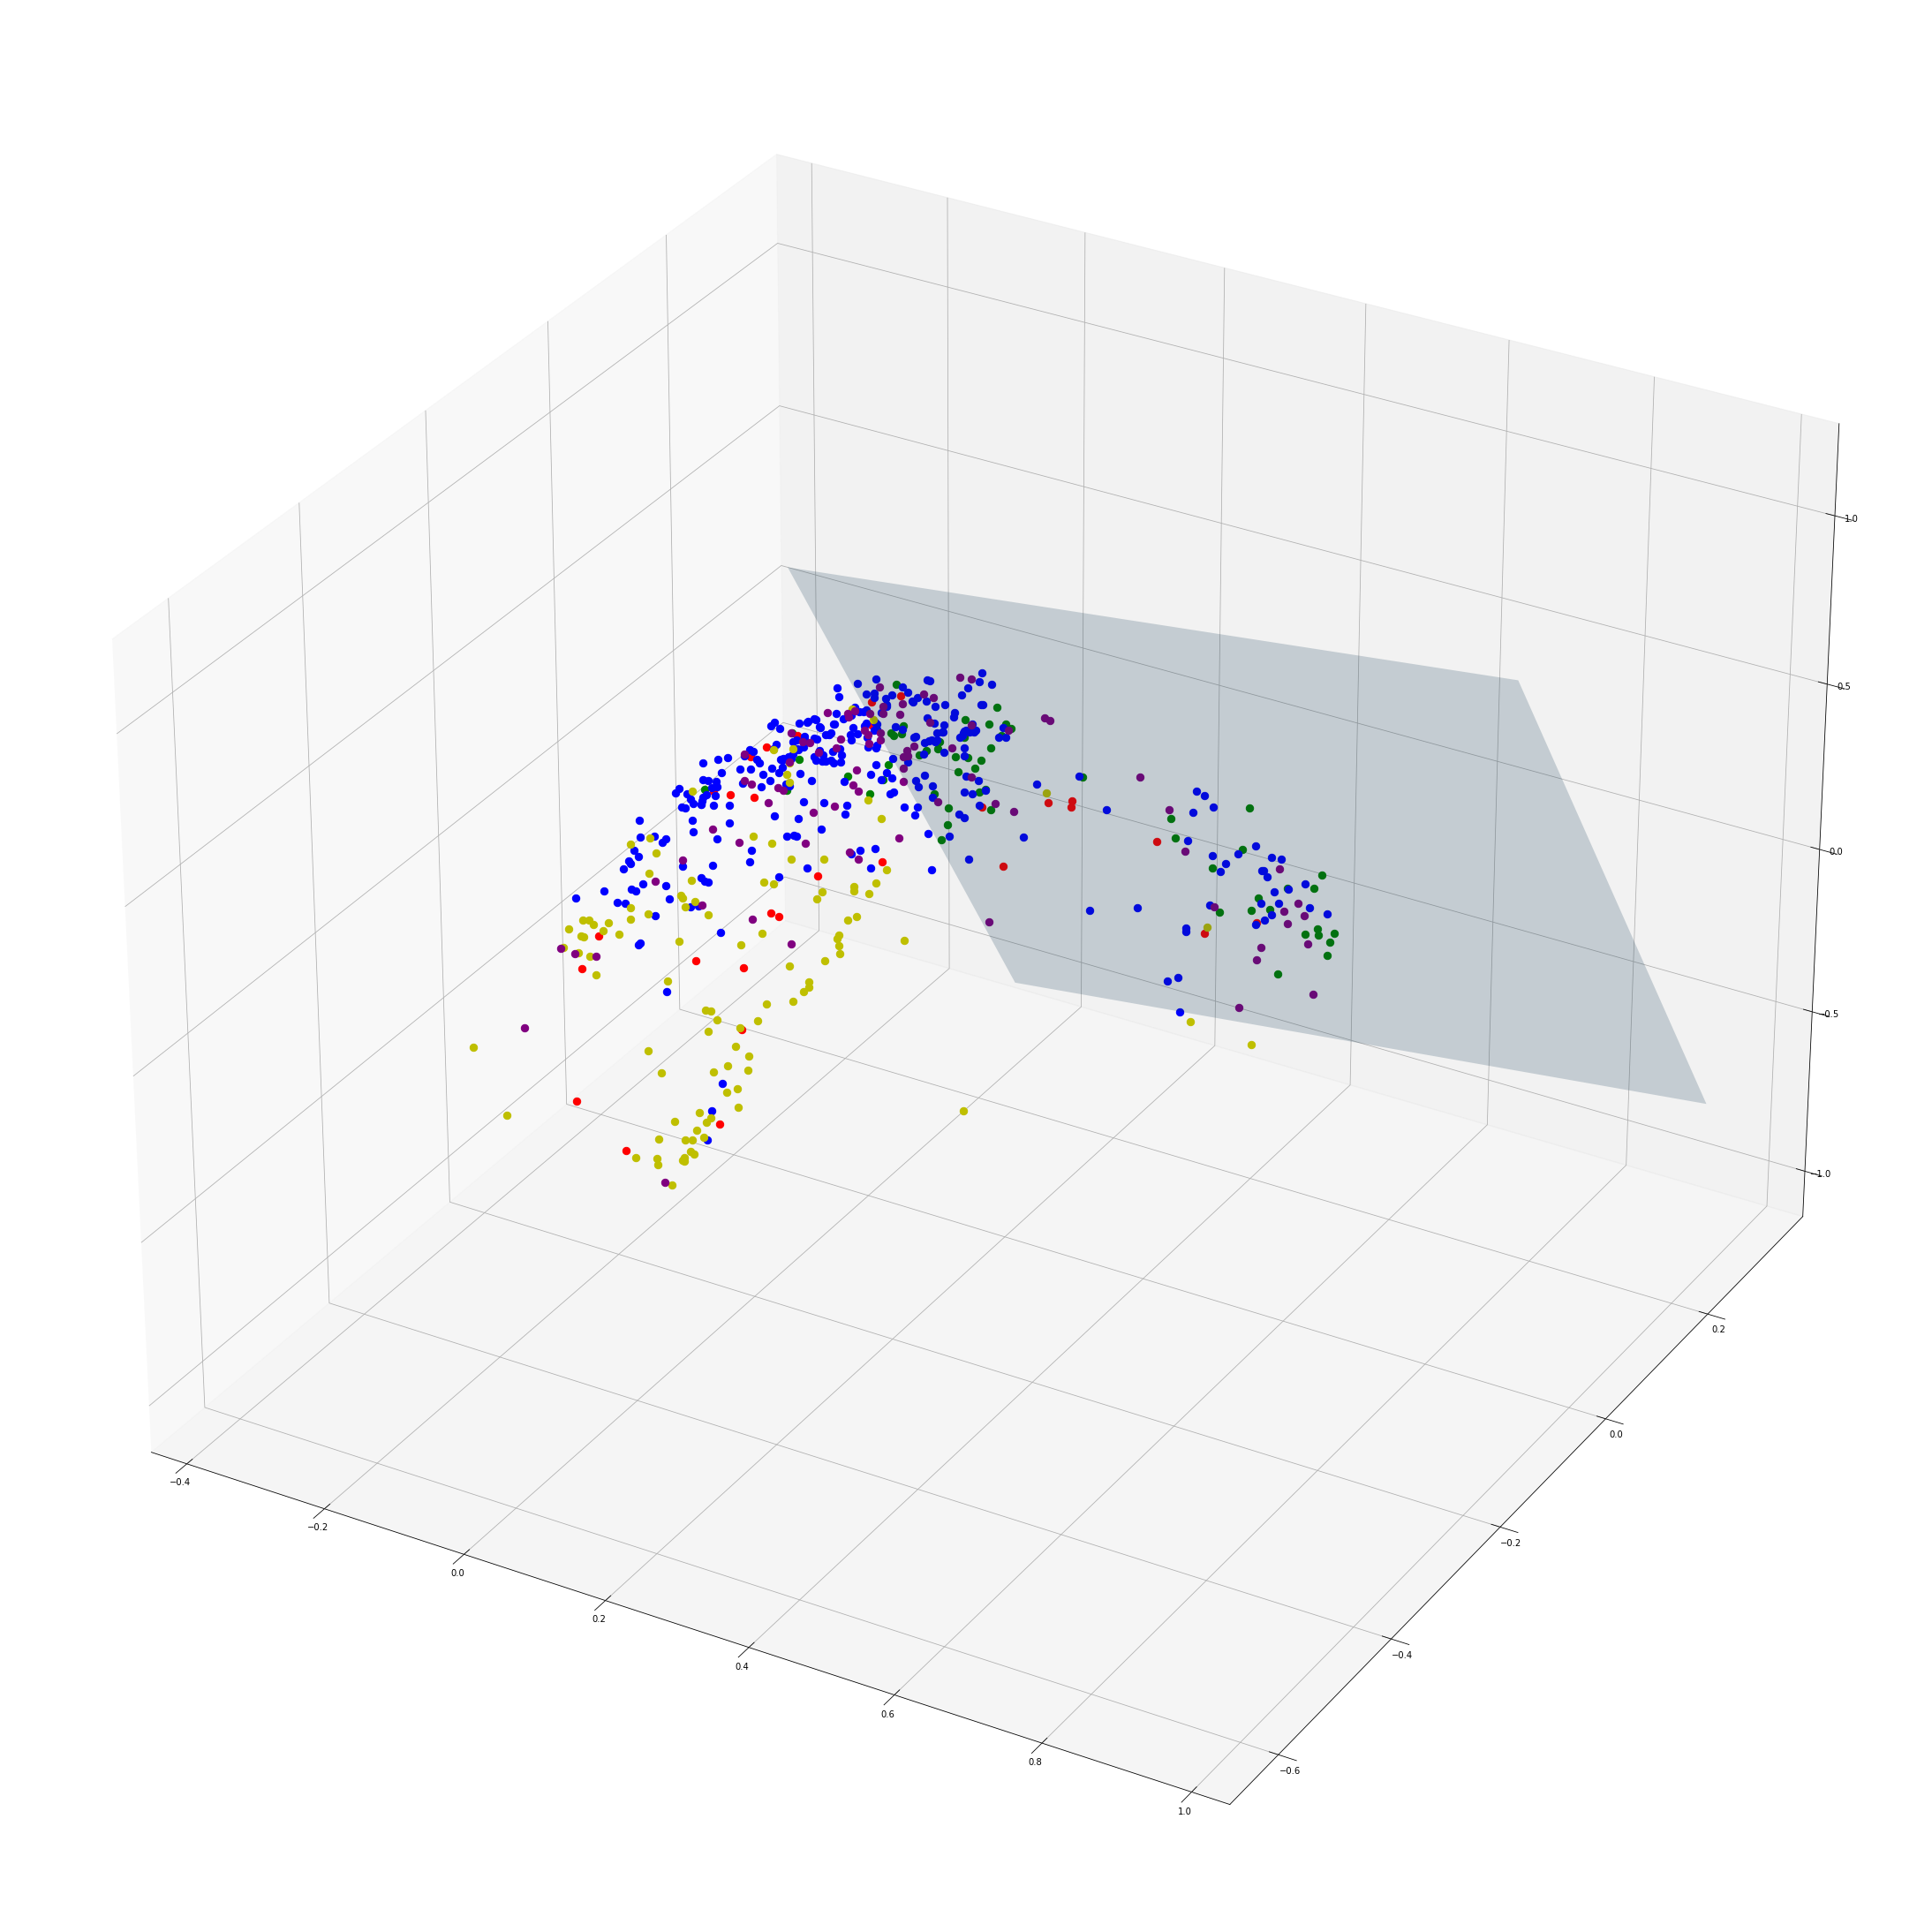

In [2]:
#Plottet die Plane

from skspatial.objects import Points, Plane
from skspatial.plotting import plot_3d

pointsHC = Points(HC_matrix)
pointsICD_r = Points(ICD_r_matrix)
pointsICD_nr = Points(ICD_nr_matrix)
pointsCCD = Points(CCD_matrix)
pointsUC = Points(UC_matrix)

plane = Plane.best_fit(pointsHC)
fig, ax = plot_3d(
    pointsHC.plotter(c='g', s=70, depthshade=False),
    pointsICD_r.plotter(c='y', s=70, depthshade=False),
    pointsICD_nr.plotter(c='r', s=70, depthshade=False),
    pointsCCD.plotter(c='purple', s=70, depthshade=False),
    pointsUC.plotter(c='b', s=70, depthshade=False),
    plane.plotter(alpha=0.2, lims_x=(-0.2,0.8), lims_y=(-0.2,0.2)), 
)

fig.set_size_inches(40, 40)
plt.savefig('Plane.png')
plt.show()



In [3]:
#Koeffizienten der Ebene
print(coef)


[-0.38826942 -1.04514839 -1.          0.17871256]


In [4]:
#Erstellt Daten für das Random Forest Modell

#Create a new DataFrame 
dataframe = pd.DataFrame(columns = ['sample_name' , 'bmi', 'calprotectin', 'sex', 'distance_Hp', 'Gesund'])

for row in pcoa.index:
    axis1 = pcoa['axis1'][row]
    axis2 = pcoa['axis2'][row]
    axis3 = pcoa['axis3'][row]
    
    sample_id = pcoa['id'][row]
    sample = df[df.sample_name.eq(sample_id)]
    
    bmi = sample['bmi'].values[0]
    if bmi == 'missing: not provided' or bmi == 'not collected':
        bmi = np.nan
        
    calprotectin = sample['calprotectin'].values[0]
    if calprotectin == 'not applicable' or calprotectin  == 'not collected':
        calprotectin = np.nan
        
    if sample['sex'].values[0] == 'male':
        sex = 1
    else:
        sex = 0
        
    distance = plane.distance_point([axis1, axis2, axis3])
     
    if any(True for val in HC['sample_name'] if val == pcoa['id'][row]):
        dataframe = dataframe.append({'sample_name' : sample_id , 'bmi' : bmi, 'calprotectin' : calprotectin, 'sex' : sex, 'distance_Hp' : distance, 'Gesund' : 1} , ignore_index=True)
    
    else:
         dataframe = dataframe.append({'sample_name' : sample_id , 'bmi' : bmi, 'calprotectin' : calprotectin, 'sex' : sex, 'distance_Hp' : distance, 'Gesund' : 0} , ignore_index=True)
    
dataframe.to_csv("data_for_random_forest.csv", index = False)
dataframe


,sample_name,bmi,calprotectin,sex,distance_Hp,Gesund
0,1629.SubjectIBD335,23,57.0,0,0.003952,0
1,1629.SubjectIBD643,NaN,23.0,0,0.031592,0
2,1629.SubjectIBD539,22,63.0,0,0.001196,1
3,1629.SubjectIBD078,26,47.0,1,0.035355,0
4,1629.SubjectIBD671,NaN,35.0,0,0.603118,0
...,...,...,...,...,...,...
611,1629.SubjectIBD421,26,1013.0,0,0.060816,0
612,1629.SubjectIBD202,28,220.0,1,0.164762,0
613,1629.SubjectIBD544,18,377.0,0,0.371970,0
614,1629.SubjectIBD422,26,67.0,1,0.009913,0


[[Text(0, 0, 'HC'),
  Text(1, 0, 'ICD_r'),
  Text(2, 0, 'ICD_nr'),
  Text(3, 0, 'CCD'),
  Text(4, 0, 'UC')]]

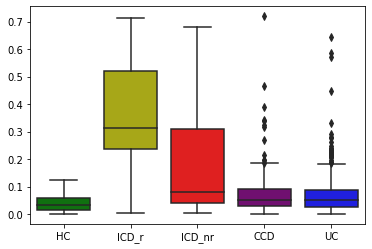

In [5]:
#Whisker Plots / Boxplots

import seaborn as sn

def distance_arr(group, plane):
    '''
    Erstellt Liste mit Distanzen zur Hp für jede Gruppe
    '''
    group_liste = []
    for i in range(0, len(group)):
        axis1 = group[i][0]
        axis2 = group[i][1]
        axis3 = group[i][2]
        dist = plane.distance_point([axis1, axis2, axis3])
        group_liste.append(dist)
    return np.array(group_liste)

HC_arr = distance_arr(HC_matrix, plane)
ICD_r_arr = distance_arr(ICD_r_matrix, plane)
ICD_nr_arr = distance_arr(ICD_nr_matrix, plane)
CCD_arr = distance_arr(CCD_matrix, plane)
UC_arr = distance_arr(UC_matrix, plane)

all_arr = [HC_arr, ICD_r_arr, ICD_nr_arr, CCD_arr, UC_arr]

ax = sn.boxplot(data=all_arr, palette=["g","y","r","purple","b"])
ax.set(xticklabels=["HC","ICD_r", "ICD_nr", "CCD", "UC"])